# 🌍 Land cover classification

Choose a location for Vertex AI https://cloud.google.com/vertex-ai/docs/general/locations

ℹ️ Make sure the Cloud Storage bucket is in the same region https://cloud.google.com/storage/docs/locations (NOT MULTI REGION)

Create bucket: https://console.cloud.google.com/storage/create-bucket

Enable APIs (TODO): Earth Engine, Dataflow, Vertex AI

Register Compute Engine service account to EE: https://signup.earthengine.google.com/#!/service_accounts
from https://console.cloud.google.com/iam-admin/iam

In [ ]:
# TODO: UPDATE WITH main BRANCH!
# github_path = 'https://raw.githubusercontent.com/GoogleCloudPlatform/python-docs-samples/main/people-and-planet-ai/land-cover-classification'
github_path = 'https://raw.githubusercontent.com/davidcavazos/python-docs-samples/ppai-landcover/people-and-planet-ai/land-cover-classification'

!pip install -r {github_path}/requirements.txt -c {github_path}/constraints.txt

# ⚠️ RESTART RUNTIME

In [1]:
# TODO: UPDATE WITH main BRANCH!
!rm -rf python-docs-samples
!git clone -b ppai-landcover https://github.com/davidcavazos/python-docs-samples/
%cd python-docs-samples/people-and-planet-ai/land-cover-classification/

Cloning into 'python-docs-samples'...
remote: Enumerating objects: 64284, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 64284 (delta 0), reused 3 (delta 0), pack-reused 64275
Receiving objects: 100% (64284/64284), 78.22 MiB | 9.26 MiB/s, done.
Resolving deltas: 100% (37537/37537), done.
/content/python-docs-samples/people-and-planet-ai/land-cover-classification


In [2]:
# TODO: DELETE THIS, BACKDOOR FOR TESTING
import os
os.environ['GOOGLE_CLOUD_PROJECT'] = 'dcavazos-lyra'
os.environ['CLOUD_STORAGE_BUCKET'] = 'dcavazos-lyra'

In [3]:
#@title My Google Cloud resources
project = "" #@param {type:"string"}
bucket = "" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Load from environment variables if available.
import os
project = os.environ.get('GOOGLE_CLOUD_PROJECT', project)
bucket = os.environ.get('CLOUD_STORAGE_BUCKET', bucket)
location = os.environ.get('CLOUD_LOCATION', location)

# Quick input validations.
assert project, '⚠️ Please provide a Google Cloud project ID'
assert bucket, '⚠️ Please provide a Cloud Storage bucket name'
assert not bucket.startswith('gs://'), f'⚠️ Please remove the gs:// prefix from the bucket name: {bucket}'
assert location, '⚠️ Please provide a Google Cloud location'

# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [4]:
import ee
import google.auth

credentials, _ = google.auth.default(
    scopes=[
        'https://www.googleapis.com/auth/cloud-platform',
        'https://www.googleapis.com/auth/earthengine',
    ]
)
ee.Initialize(credentials, project=project)

# Understand the data

- What is a land cover map?
- Why Sentinel 2 as inputs?
- Model input and output shapes

In [5]:
CLASSIFICATIONS = {
    '💧 Water':              '449cda',
    '🌳 Trees':              '3d7c49',
    '🌾 Grass':              '8ab052',
    '🌿 Flooded vegetation': '7c86c7',
    '🚜 Crops':              'e19832',
    '🪴 Shrub and scrub':    'dfc35b',
    '🏗️ Built-up areas':     'c52918',
    '🪨 Bare ground':        'a29d90',
    '❄️ Snow and ice':       'b4a0e0',
}
PALETTE = list(CLASSIFICATIONS.values())

def display_legend():
  reset_color = '\u001b[0m'
  colored = lambda red, green, blue: f"\033[48;2;{red};{green};{blue}m"
  for name, color in CLASSIFICATIONS.items():
    red   = int(color[0:2], 16)
    green = int(color[2:4], 16)
    blue  = int(color[4:6], 16)
    print(f"{colored(red, green, blue)}   {reset_color} {name}")

display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


## **Inputs**: Sentinel 2 satellite images

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

Mask (hide) pixels covered by clouds or cirrus clouds.

TODO: explain how to mask clouds

In [6]:
import folium

def get_sentinel2_image(start_date: str, end_date: str) -> ee.Image:
    def mask_sentinel2_clouds(image: ee.Image) -> ee.Image:
        CLOUD_BIT = 10
        CIRRUS_CLOUD_BIT = 11
        bit_mask = (1 << CLOUD_BIT) | (1 << CIRRUS_CLOUD_BIT)
        mask = image.select("QA60").bitwiseAnd(bit_mask).eq(0)
        return image.updateMask(mask)

    return (
        ee.ImageCollection("COPERNICUS/S2")
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
        .map(mask_sentinel2_clouds)
        .median()
    )

sentinel2_image = get_sentinel2_image('2020-1-1', '2021-01-1')

vis_params = {
  'min': 0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}
folium.Map(
    location=[38.6561723, -9.0624997],
    zoom_start=12,
    tiles=sentinel2_image.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

## **Outputs**: Land cover map

https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100

In [7]:
import folium

def get_landcover_image() -> ee.Image:
    # Remap the ESA classifications into the Dynamic World classifications
    fromValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    toValues = [1, 5, 2, 4, 6, 7, 8, 0, 3, 3, 7]
    return (
        ee.ImageCollection("ESA/WorldCover/v100")
        .first()
        .select("Map")
        .remap(fromValues, toValues)
        .rename("landcover")
    )

landcover_image = get_landcover_image()

vis_params = {
  'bands': ['landcover'],
  'palette': PALETTE,
}
folium.Map(
    location=[38.6561723, -9.0624997],
    zoom_start=12,
    tiles=landcover_image.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [8]:
display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


TODO: add note on how to use dynamic world

# Create the datasets

## Sample training points

In [9]:
import csv
import random

# Load the regions from the CSV file.
with open("data/regions-small.csv") as f:
  csv_reader = csv.DictReader(f)
  regions = [
      {key: float(value) for key, value in row.items()}
      for row in csv_reader
  ]

# Let's see how one region looks like.
print(f"region: {regions[0]}")
print(f"total number of regions: {len(regions)}")

region: {'west': 23.920116850704154, 'south': 64.335401033452, 'east': 31.920116850704154, 'north': 72.335401033452}
total number of regions: 10


In [10]:
from typing import Dict, Iterable

def sample_random_points(region: Dict[str, float], points_per_region: int = 10) -> Iterable[Dict[str, float]]:
  for _ in range(points_per_region):
    yield {
        'lat': random.uniform(region['south'], region['north']),
        'lon': random.uniform(region['west'], region['east']),
    }

for coords in sample_random_points(regions[0], points_per_region=5):
  print(f"coords: {coords}")

coords: {'lat': 67.79465852124117, 'lon': 31.278045926902603}
coords: {'lat': 67.67512123303025, 'lon': 27.494498904996497}
coords: {'lat': 65.19952627836109, 'lon': 24.390335571647224}
coords: {'lat': 66.9818986739829, 'lon': 30.213647048346562}
coords: {'lat': 68.91651409851376, 'lon': 24.03900074589639}


## Get patches from Earth Engine

In [11]:
from typing import List, Tuple
import io
import requests
import numpy as np

INPUT_BANDS = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
OUTPUT_BANDS = ["landcover"]

def get_patch(coords: Dict[str, float], bands: List[str], patch_size: int, scale: int) -> np.ndarray:
  sentinel2_image = get_sentinel2_image("2020-1-1", "2021-1-1")
  landcover_image = get_landcover_image()
  image = sentinel2_image.addBands(landcover_image)

  point = ee.Geometry.Point([coords["lon"], coords["lat"]])
  url = image.getDownloadURL({
      "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
      "dimensions": [patch_size, patch_size],
      "format": "NPY",
      "bands": bands,
  })
  np_bytes = requests.get(url).content
  print(f"Got patch for {coords}")
  return np.load(io.BytesIO(np_bytes), allow_pickle=True)

coords = {'lat': 71.36045598771753, 'lon': 24.984466982503548}
patch = get_patch(coords, INPUT_BANDS + OUTPUT_BANDS, patch_size=8, scale=10)
print(f"patch shape={patch.shape} bands={len(patch.dtype)}")
print(f"dtype: {patch.dtype}")

Got patch for {'lat': 71.36045598771753, 'lon': 24.984466982503548}
patch shape=(8, 8) bands=14
dtype: [('B1', '<f8'), ('B2', '<f8'), ('B3', '<f8'), ('B4', '<f8'), ('B5', '<f8'), ('B6', '<f8'), ('B7', '<f8'), ('B8', '<f8'), ('B8A', '<f8'), ('B9', '<f8'), ('B10', '<f8'), ('B11', '<f8'), ('B12', '<f8'), ('landcover', 'u1')]


## Serialize into TFRecords

In [12]:
import tensorflow as tf

def serialize(patch: np.ndarray) -> bytes:
  features = {
      name: tf.train.Feature(
          float_list=tf.train.FloatList(value=patch[name].flatten())
      )
      for name in INPUT_BANDS + OUTPUT_BANDS
  }
  example = tf.train.Example(features=tf.train.Features(feature=features))
  return example.SerializeToString()

serialized = serialize(patch)
print(f"serialized: {type(serialized).__name__} ({len(serialized)})")

serialized: bytes (3822)


## Run in Apache Beam

In [13]:
points_per_region =  2#@param {type:"integer"}
training_patch_size =  8#@param {type:"integer"}

# Load from environment variables if available.
points_per_region = int(os.environ.get('POINTS_PER_REGION', points_per_region))
training_patch_size = int(os.environ.get('TRAINING_PATCH_SIZE', training_patch_size))

https://beam.apache.org/documentation/runners/direct/#parallel-execution

In [14]:
import apache_beam as beam
import random
from typing import Any

training_validation_ratio = [90, 10]

def split_dataset(element: Any, num_partitions: int) -> int:
  return random.choices([0, 1], weights=training_validation_ratio)[0]

with beam.Pipeline() as pipeline:
  training_data, validation_data = (
      pipeline
      | "Create regions" >> beam.Create(regions)
      | "Sample random points" >> beam.FlatMap(sample_random_points, points_per_region)
      | "Get patch" >> beam.Map(get_patch, INPUT_BANDS + OUTPUT_BANDS, training_patch_size, scale=10)
      | "Serialize" >> beam.Map(serialize)
      | "Split dataset" >> beam.Partition(split_dataset, 2)
  )

  training_data | "Write training data" >> beam.io.tfrecordio.WriteToTFRecord(
      "training-data", file_name_suffix=".tfrecord.gz"
  )
  validation_data | "Write validation data" >> beam.io.tfrecordio.WriteToTFRecord(
      "validation-data", file_name_suffix=".tfrecord.gz"
  )

Got patch for {'lat': 65.46390930815024, 'lon': 26.16742961385289}
Got patch for {'lat': 71.82157367390718, 'lon': 24.38680665647091}
Got patch for {'lat': 69.1527197055873, 'lon': 61.633129706639046}
Got patch for {'lat': 63.94722835520815, 'lon': 66.96353286137453}
Got patch for {'lat': 66.51788623793901, 'lon': 84.0668934591994}
Got patch for {'lat': 65.77440833773564, 'lon': 89.98371139756311}
Got patch for {'lat': 62.55209172335587, 'lon': -130.2529435034538}
Got patch for {'lat': 68.26448846624132, 'lon': -129.1730147676603}
Got patch for {'lat': 64.25071969644662, 'lon': -23.127267173620673}
Got patch for {'lat': 65.8817073871164, 'lon': -20.93202891083215}
Got patch for {'lat': 58.41331307821912, 'lon': 67.80683290357122}
Got patch for {'lat': 63.66564433411678, 'lon': 70.1000959693049}
Got patch for {'lat': 60.24429153179764, 'lon': 10.605789113316412}
Got patch for {'lat': 56.651085070384575, 'lon': 11.685346297765303}
Got patch for {'lat': 58.013843749417866, 'lon': 14.27045

In [15]:
!ls -lh *.tfrecord.gz

-rw-r--r-- 1 root root 21K Apr 21 21:04 training-data-00000-of-00001.tfrecord.gz
-rw-r--r-- 1 root root  20 Apr 21 21:04 validation-data-00000-of-00001.tfrecord.gz


## Run in Dataflow

In [16]:
points_per_region =  500#@param {type:"integer"}
training_patch_size =  63#@param {type:"integer"}

# Load from environment variables if available.
points_per_region = int(os.environ.get('POINTS_PER_REGION', points_per_region))
training_patch_size = int(os.environ.get('TRAINING_PATCH_SIZE', training_patch_size))

In [37]:
import subprocess

cmd = [
    f"python",
    f"create_datasets.py",
    f"--training-file=gs://{bucket}/land-cover/training-data",
    f"--validation-file=gs://{bucket}/land-cover/validation-data",
    f"--regions-file=data/regions.csv",
    f"--points-per-region={points_per_region}",
    f"--patch-size={training_patch_size}",
    f"--runner=DataflowRunner",
    f"--project={project}",
    f"--region={location}",
    f"--temp_location=gs://{bucket}/land-cover/temp",
    f"--setup_file=./setup.py",
]
process = subprocess.run(cmd, check=True, capture_output=True)
print(process.stdout.decode('utf-8'))

https://console.cloud.google.com/dataflow/jobs

# Train the model

## Inspect the datasets

In [120]:
import tensorflow as tf

filenames = tf.data.Dataset.list_files(f"training-data*.tfrecord.gz")
dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP')
for x in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(x.numpy())
  for _, feature in example.ListFields():
    for _, field in feature.ListFields():
      for name, values in sorted(field.items()):
        print(f"{name}: float ({len(values.float_list.value)})")

B1: float (64)
B10: float (64)
B11: float (64)
B12: float (64)
B2: float (64)
B3: float (64)
B4: float (64)
B5: float (64)
B6: float (64)
B7: float (64)
B8: float (64)
B8A: float (64)
B9: float (64)
landcover: float (64)


## Read the datasets

In [60]:
print(f"Number of classifications: {len(CLASSIFICATIONS)}")
print(f"Training patch size: {training_patch_size}")
print(f"Training patch area: {training_patch_size * training_patch_size}")

Number of classifications: 9
Training patch size: 8
Training patch area: 64


https://www.tensorflow.org/guide/data_performance

In [62]:
from typing import Dict, Tuple

def preprocess(patch: Dict[str, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
    inputs = tf.stack([patch[band] for band in INPUT_BANDS], axis=-1)
    outputs = tf.one_hot(tf.cast(patch["landcover"], tf.uint8), len(CLASSIFICATIONS))
    return (inputs, outputs)

def read_dataset(file_pattern: str) -> tf.data.Dataset:
  input_shape = (training_patch_size, training_patch_size)
  features_dict = {
      band_name: tf.io.FixedLenFeature(input_shape, tf.float32)
      for band_name in INPUT_BANDS + OUTPUT_BANDS
  }
  return (
      tf.data.Dataset.list_files(file_pattern)
      .interleave(lambda filename: tf.data.TFRecordDataset(filename, compression_type="GZIP"))
      .batch(4)
      .map(lambda batch: tf.io.parse_example(batch, features_dict))
      .map(preprocess)
  )

training_dataset = read_dataset(f"training-data*.tfrecord.gz")
validation_dataset = read_dataset(f"validation-data*.tfrecord.gz")
for inputs, outputs in training_dataset.take(1):
  print(f"inputs:  {inputs.shape}")
  print(f"outputs: {outputs.shape}")

inputs:  (4, 8, 8, 13)
outputs: (4, 8, 8, 9)


(batch_size, width, height, num_bands)

## Model architecture

TODO: add diagram

- https://keras.io/api/layers/core_layers/input/
- https://keras.io/api/layers/preprocessing_layers/numerical/normalization/
- https://keras.io/api/layers/convolution_layers/convolution2d/
- https://keras.io/api/layers/convolution_layers/convolution2d_transpose/
- https://keras.io/api/layers/core_layers/dense/
- https://keras.io/api/optimizers/
- https://keras.io/api/losses/

In [63]:
kernel_size = 5 #@param {type:"integer"}

# Load from environment variables if available.
kernel_size = int(os.environ.get('KERNEL_SIZE', kernel_size))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normalized (Normalization)  (None, None, None, 13)    27        
                                                                 
 Conv2D (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 DeConv2D (Conv2DTranspose)  (None, None, None, 16)    12816     
                                                                 
 LandCover (Dense)           (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


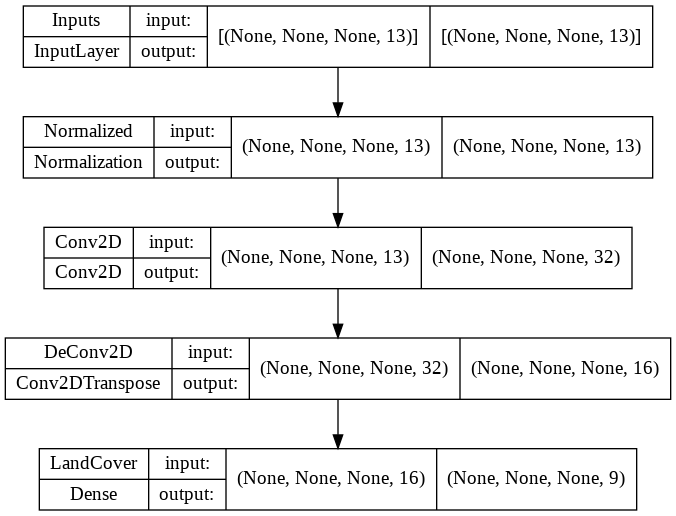

In [64]:
import tensorflow as tf

normalization = tf.keras.layers.Normalization(name="Normalized")
normalization.adapt(training_dataset.map(lambda x, _: x))

model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, None, len(INPUT_BANDS)), name="Inputs"),
    normalization,
    tf.keras.layers.Conv2D(filters=32, kernel_size=kernel_size, activation="relu", name="Conv2D"),
    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=kernel_size, activation="relu", name="DeConv2D"),
    tf.keras.layers.Dense(len(CLASSIFICATIONS), activation="softmax", name="LandCover"),
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
    
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Fit the model

In [65]:
model.fit(
    training_dataset.shuffle(10),
    validation_data=validation_dataset,
    epochs=10,
)
model.save('local-model')

Epoch 1/10
9/9 [==============================] - 1s 41ms/step - loss: 1.9506 - accuracy: 0.1871 - val_loss: 2.3562 - val_accuracy: 0.2625
Epoch 2/10
9/9 [==============================] - 0s 15ms/step - loss: 1.3368 - accuracy: 0.5920 - val_loss: 2.9188 - val_accuracy: 0.3750
Epoch 3/10
9/9 [==============================] - 0s 15ms/step - loss: 1.0982 - accuracy: 0.6674 - val_loss: 3.5493 - val_accuracy: 0.4375
Epoch 4/10
9/9 [==============================] - 0s 14ms/step - loss: 0.9658 - accuracy: 0.6996 - val_loss: 3.8243 - val_accuracy: 0.4469
Epoch 5/10
9/9 [==============================] - 0s 14ms/step - loss: 0.8993 - accuracy: 0.6982 - val_loss: 3.9462 - val_accuracy: 0.4156
Epoch 6/10
9/9 [==============================] - 0s 14ms/step - loss: 0.8093 - accuracy: 0.7371 - val_loss: 3.8084 - val_accuracy: 0.5156
Epoch 7/10
9/9 [==============================] - 0s 17ms/step - loss: 0.7395 - accuracy: 0.7554 - val_loss: 3.8734 - val_accuracy: 0.4563
Epoch 8/10
9/9 [===========

INFO:tensorflow:Assets written to: local-model/assets


INFO:tensorflow:Assets written to: local-model/assets


# Get predictions

## Fetch input data

https://en.wikipedia.org/wiki/Camp_Fire_(2018)

https://beam.apache.org/releases/pydoc/current/apache_beam.io.filesystems.html

https://beam.apache.org/releases/pydoc/current/apache_beam.io.filesystems.html#apache_beam.io.filesystems.FileSystems.create

In [101]:
# The fire was in November 2018.
years = [2017, 2018, 2019, 2020, 2021]
coordinates = {
    'Camp fire': {'lat': 39.7818, 'lon': -121.5124},
}
regions_to_predict = [{'name': 'Camp fire', 'year': year} for year in years]

for region in regions_to_predict:
  print(f"region={region} coordinates={coordinates[region['name']]}")

region={'name': 'Camp fire', 'year': 2017} coordinates={'lat': 39.7818, 'lon': -121.5124}
region={'name': 'Camp fire', 'year': 2018} coordinates={'lat': 39.7818, 'lon': -121.5124}
region={'name': 'Camp fire', 'year': 2019} coordinates={'lat': 39.7818, 'lon': -121.5124}
region={'name': 'Camp fire', 'year': 2020} coordinates={'lat': 39.7818, 'lon': -121.5124}
region={'name': 'Camp fire', 'year': 2021} coordinates={'lat': 39.7818, 'lon': -121.5124}


In [66]:
prediction_patch_size =  256#@param {type:"integer"}

# Load from environment variables if available.
prediction_patch_size = int(os.environ.get('PREDICTION_PATCH_SIZE', prediction_patch_size))

In [132]:
import ee
import numpy as np
from typing import Dict

def fetch_input_patch(region: Dict, patch_size: int = 256, scale: int = 10) -> np.ndarray:
  image = get_sentinel2_image(f"{region['year']}-01-01", f"{region['year']}-12-31")

  coords = coordinates[region['name']]
  point = ee.Geometry.Point([coords['lon'], coords['lat']])
  url = image.getDownloadURL(
      {
          "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
          "dimensions": [patch_size, patch_size],
          "format": "NPY",
          "bands": INPUT_BANDS,
      }
  )
  np_bytes = requests.get(url).content
  structured_array = np.load(io.BytesIO(np_bytes), allow_pickle=True)
  return np.stack([structured_array[band] for band in INPUT_BANDS], axis=-1)

input_patch_year1 = fetch_input_patch(regions_to_predict[0], prediction_patch_size, scale=10)
input_patch_year2 = fetch_input_patch(regions_to_predict[0], prediction_patch_size, scale=10)
print(f"input_patch: {input_patch_year1.shape}")

input_patch: (256, 256, 13)


## Visualize inputs

sentinel2_image: uint8 (256, 256, 3)


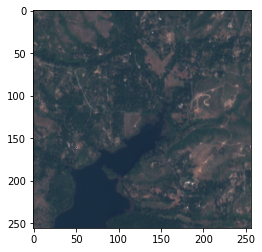

In [138]:
import matplotlib.pyplot as plt

def render_rgb_images(values: np.ndarray, min=0.0, max=1.0, gamma=1.0) -> np.ndarray:
  scaled_values = (values - min) / (max - min)
  gamma_corrected_values = scaled_values ** (1.0 / gamma)
  rgb_values = gamma_corrected_values * 255
  return rgb_values.astype(np.uint8)

def render_sentinel2(input_batch: np.ndarray) -> np.ndarray:
  red   = input_batch[..., 3]  # B4
  green = input_batch[..., 2]  # B3
  blue  = input_batch[..., 1]  # B2
  rgb_input_batch = np.stack([red, green, blue], axis=-1)
  return render_rgb_images(rgb_input_batch, max=3000)

sentinel2_image = render_sentinel2(input_patch_year1)

print(f"sentinel2_image: {sentinel2_image.dtype} {sentinel2_image.shape}")
plt.imshow(sentinel2_image)

## Model prediction

In [134]:
import tensorflow as tf

model = tf.keras.models.load_model(f"local-model")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normalized (Normalization)  (None, None, None, 13)    27        
                                                                 
 Conv2D (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 DeConv2D (Conv2DTranspose)  (None, None, None, 16)    12816     
                                                                 
 LandCover (Dense)           (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


In [135]:
input_batch = np.stack([input_patch_year1, input_patch_year2])
probabilities = model.predict(input_batch)
print(f"probabilities: {probabilities.dtype} {probabilities.shape}")

probabilities: float32 (2, 256, 256, 9)


## Visualize outputs

landcover images: uint8 (2, 256, 256, 3)
    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


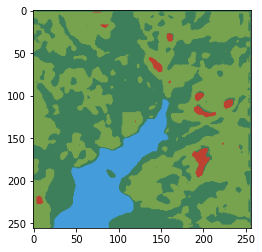

In [140]:
def render_classifications(probabilities: np.ndarray, palette: list) -> np.ndarray:
  # Create a color map from a hex color palette.
  xs = np.linspace(0, len(palette) - 1, 256)
  indices = np.arange(len(palette))
  color_map = np.array([
        np.interp(xs, indices, [int(c[0:2], 16) for c in palette]),  # reds
        np.interp(xs, indices, [int(c[2:4], 16) for c in palette]),  # greens
        np.interp(xs, indices, [int(c[4:6], 16) for c in palette]),  # blues
  ]).astype(np.uint8).transpose()

  # Convert the probabilities into prediction indices and map them to the color map.
  predictions = np.argmax(probabilities, axis=-1)
  color_indices = (predictions / len(CLASSIFICATIONS) * 255).astype(np.uint8)
  return np.take(color_map, color_indices, axis=0)

def render_landcover(probabilities: np.ndarray) -> np.ndarray:
  palette = list(CLASSIFICATIONS.values())
  return render_classifications(probabilities, palette)

landcover_images = render_landcover(probabilities)

print(f"landcover images: {landcover_images.dtype} {landcover_images.shape}")
plt.imshow(landcover_images[0])
display_legend()

# Get predictions in Apache Beam

In [ ]:
# filename = f"predictions/{region['year']}.npz"
# with FileSystems.create(filename) as f:
#   np.savez_compressed(f, patch=patch)
#   print(f"Created {filename}")

In [90]:
!ls -lh predictions/

total 5.3M
-rw-r--r-- 1 root root 1.1M Apr 21 19:50 2017.npz
-rw-r--r-- 1 root root 1.1M Apr 21 19:50 2018.npz
-rw-r--r-- 1 root root 1.1M Apr 21 19:50 2019.npz
-rw-r--r-- 1 root root 1.1M Apr 21 19:50 2020.npz
-rw-r--r-- 1 root root 1.1M Apr 21 19:50 2021.npz


In [34]:
from apache_beam.io.filesystems import FileSystems
import numpy as np

def load_patch(filename: str) -> np.ndarray:
  with FileSystems.open(filename) as f:
    return np.load(f)['patch']

input_batch = np.stack([
    load_patch(f"predictions/🔥 Camp fire/{year}.npz")
    for year in years
])
print(f"input_batch: {input_batch.dtype} {input_batch.shape}")

input_batch: float64 (5, 256, 256, 13)


## Land cover change

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


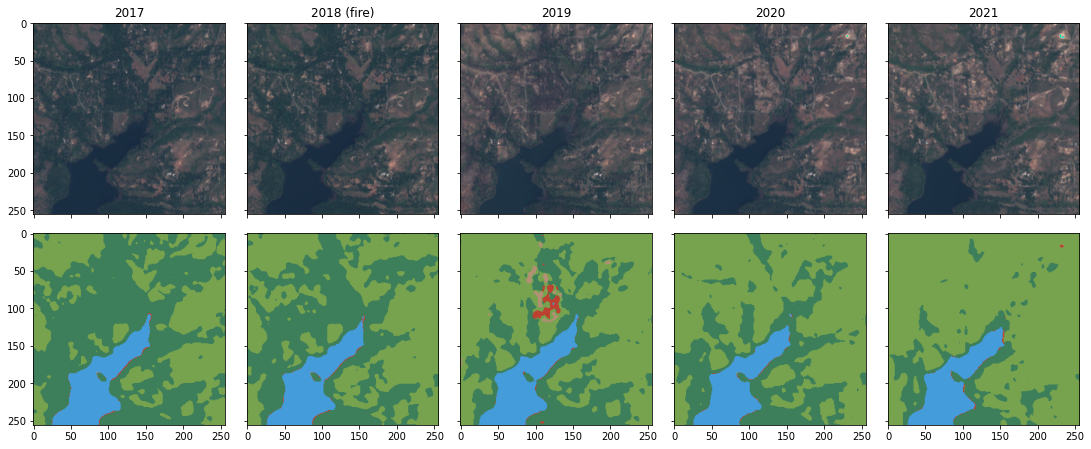

In [39]:
def display_land_cover_change(sentinel2_images: np.ndarray, landcover_images: np.ndarray):
  img_size = 3
  figsize = (img_size * len(years), img_size * 2)
  figure, plot_rows = plt.subplots(2, len(years), figsize=figsize, sharex=True, sharey=True)
  figure.tight_layout(pad=0)

  for title, plot, image in zip(years, plot_rows[0], sentinel2_images):
    plot.set_title(title if title != 2018 else '2018 (fire)')
    plot.imshow(image)
  for plot, image in zip(plot_rows[1], landcover_images):
    plot.imshow(image)

  display_legend()

display_land_cover_change(sentinel2_images, landcover_images)

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


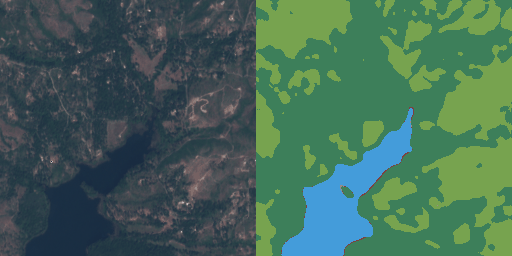

In [40]:
import os
import imageio
from IPython.display import Image

def land_cover_change_gif(sentinel2_images: np.ndarray, landcover_images: np.ndarray):
  display_legend()

  frames = np.concatenate([sentinel2_images, landcover_images], axis=2)
  imageio.mimwrite('landcover-change.gif', frames, duration=1)
  return Image(open('landcover-change.gif', 'rb').read())

land_cover_change_gif(sentinel2_images, landcover_images)

# Deploying in Google Cloud

## Train the model in Vertex AI

https://cloud.google.com/vertex-ai/docs/training/pre-built-containers

https://pypi.org/project/google-cloud-aiplatform/

https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.CustomTrainingJob

In [ ]:
from google.cloud import aiplatform

epochs = 200

aiplatform.init(project=project, location=location, staging_bucket=bucket)

job = aiplatform.CustomTrainingJob(
    display_name=f"dynamic_world_large_{epochs}", # TODO: simplify
    script_path="train_model.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest",
)

model = job.run(
    accelerator_type='NVIDIA_TESLA_K80',
    accelerator_count=1,
    args=[
        # TODO: simplify
        f'--training-file=gs://{bucket}/land-cover/training-5000-15.tfrecord.gz',
        f'--validation-file=gs://{bucket}/land-cover/validation-5000-15.tfrecord.gz',
        f'--save-model-to=gs://{bucket}/land-cover/model-large-{epochs}',
        f'--epochs={epochs}',
    ],
    sync=False,
)

https://console.cloud.google.com/vertex-ai/training/training-pipelines

In [ ]:
print(f"input_batch: {input_batch.dtype} {input_batch.shape}")

input_batch: float64 (5, 511, 511, 13)


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(f"gs://{bucket}/land-cover/model-large-200")
probabilities = model.predict(input_batch)

sentinel2_images = render_sentinel2(input_batch)
landcover_images = render_landcover(probabilities)

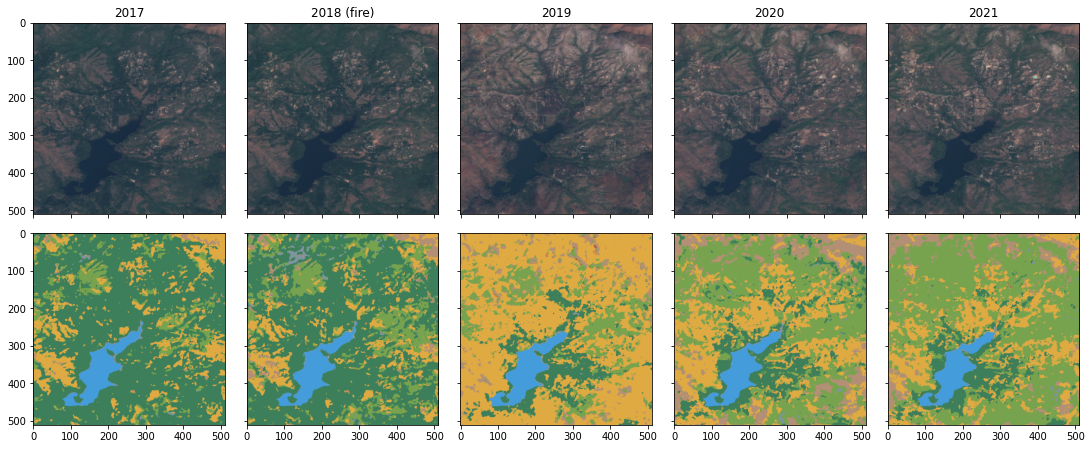

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


In [ ]:
display_land_cover_change(sentinel2_images, landcover_images)

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


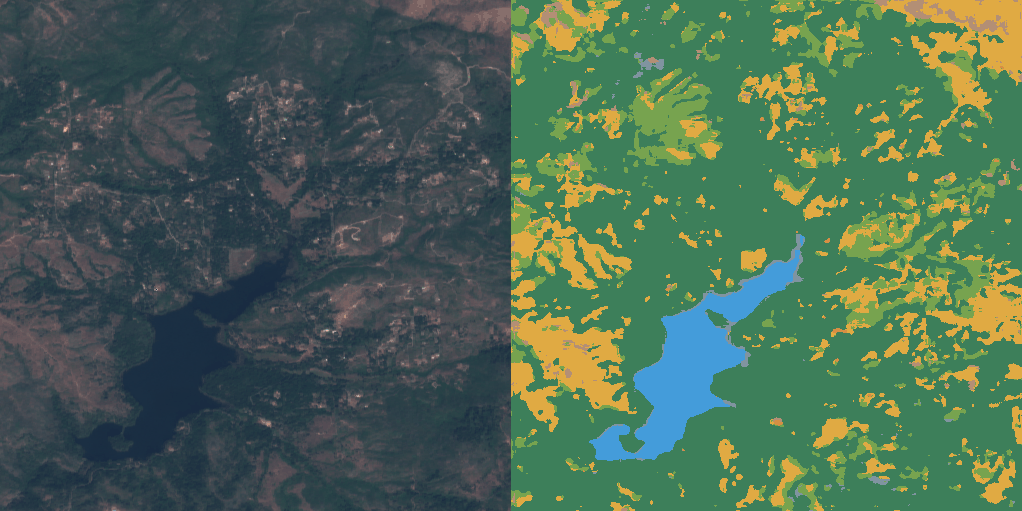

In [ ]:
land_cover_change_gif(sentinel2_images, landcover_images)

## Online predictions from Cloud Run

## Batch predictions from Dataflow

## Online predictions from Vertex AI

> Indented block



## Batch predictions from Vertex AI